## Contents<a id='3.1_Contents'></a>
  * [3.1 Introduction](#3.1_Contents)
  * [3.2 Problem Statement](#2.2_Problem_statement)
  * [3.3 Data Wrangling](#3.3)
      * [3.3.1 Data Wrangling Summary](#3.3.1)
      * [3.3.2 Get the Data](#3.3.2)
      * [3.3.3 Explore the Data](#3.3.3)
      * [3.3.4 Transform the Data](#3.3.4)
  * [3.4 Exploratory Data Analysis](#3.4)
      * [3.4.1 Exploratory Data Analysis Summary](#3.4.1)
      * [3.4.2 Univariate Analysis](#3.4.2)
      * [3.4.3 Bivariate Analysis](#3.4.3)
      * [3.4.4 Correlation Analysis](#3.4.4)
      * [3.4.5 Temporal Analysis of Case Trends Over Time](#3.4.5)
      * [3.4.6 Text Analysis](#3.4.6)
      * [3.4.7 Case and Court Analysis](#3.4.7)
      * [3.4.8 Network Analysis of Cited Cases](#3.4.8)
      * [3.4.9 Analysis of Judges and Their Opinions](#3.4.9)
  * [3.5 Feature Engineering](#3.5)
  * [3.6 Model Generation and Evaluation](#3.6)
      * [3.6.1 Evaluation summary](#3.6.1)
      * [3.6.2 Named Entity Recognition (NER)](#3.6.2)
      * [3.6.3 Text Summarization](#3.6.3)
      * [3.6.4 Document Classification](#3.6.4)
  * [3.7 Future Recommendations](#3.7)

# 3.1 Introduction<a id='3.1_Introduction'></a>

Legal professionals are inundated with a vast array of complex documents, including contracts, case law, judicial opinions, and oral arguments. These documents require meticulous analysis and summarization to extract pertinent information, a process that is currently manual, time-consuming, and prone to errors. The SCOTUS dataset, containing a wealth of legal documents from the U.S. Supreme Court, presents an opportunity to apply Natural Language Processing (NLP) techniques to automate and enhance the analysis of these documents. By leveraging NLP, we aim to develop a system that can efficiently extract key information, summarise content, and classify documents based on their content, such as contract types or case law topics. This will not only save time but also increase the accuracy and consistency of legal document analysis.

# 3.2 Problem Statement<a id='3.2_Problem_statement'></a>

Can key information be automatically extracted from legal documents and can these documents be accurately classified and summarised using NLP techniques to aid legal professionals in their research and decision-making processes?

# 3.3 Data Wrangling<a id='3.3'></a>

## 3.3.1 Data Wrangling Summary<a id='3.3.1'></a>

In this step:

1) Imported json files and converted them into a dataframe. Converting the nested json structures were challenging so normalizing the columns with complicated structures separately. Also, calculating the load times just to plan the data import of files accordingly.
2) Explored data columns using head(), info(), shape,describe.
3) Cleansed data after we counted null values and unique values per column. Also removed all rows where found NaN in irrelevant columns, removed the columns with most of NaN value. a) Using casebody.Judges last value from the list if multiple values exist.
    b) Calculating the case_length using first_page and last_page, we had to convert the first_page and last_page to numeric values to perform this action.

## 3.3.2 Get the data<a id='3.3.2'></a>

In [171]:
import requests
import zipfile
import os
import json
import pandas as pd
import time


def expand_nested_columns(df):
    """
    Expands nested columns like citations and casebody.opinions, renames casebody.judges.
    
    Args:
        df (pd.DataFrame): DataFrame containing nested columns to expand.
        
    Returns:
        pd.DataFrame: DataFrame with expanded columns.
    """
    start_time = time.time()

    # Expand 'citations' column
    if 'citations' in df.columns:
        print("Expanding 'citations' column")
        
        # Ensure that 'citations' is a list of dictionaries
        if df['citations'].apply(lambda x: isinstance(x, list) and all(isinstance(i, dict) for i in x)).all():
            # Normalize 'citations' column
            # Explode lists if necessary
            df = df.explode('citations', ignore_index=True)
            citations_df = pd.json_normalize(df['citations'])
            citations_df.columns = [f'citations_{col}' for col in citations_df.columns]
            df = df.drop(columns=['citations']).join(citations_df)
        else:
            print("'citations' column data is not in expected format")
    
    # Expand 'casebody.opinions' and rename 'casebody.opinions.author' to 'casebody.judges'
    if 'casebody' in df.columns and 'casebody.opinions' in df.columns:
        print("Expanding 'casebody' column")
        
        casebody_opinions_df = pd.json_normalize(df['casebody.opinions'])
        casebody_opinions_df.columns = [f'casebody_opinions_{col}' for col in casebody_opinions_df.columns]
        df = df.join(casebody_opinions_df)
        
        # Rename 'casebody_opinions_author' to 'casebody_judges'
        if 'casebody_opinions_author' in casebody_opinions_df.columns:
            df.rename(columns={'casebody_opinions_author': 'casebody_judges'}, inplace=True)
        
        # Rename 'casebody.judges' to 'casebody_judges_old' if it exists
        if 'casebody.judges' in df.columns:
            df.rename(columns={'casebody.judges': 'casebody_judges_old'}, inplace=True)

        # Drop the original 'casebody' column after expansion
        df.drop(columns=['casebody'], inplace=True)

    end_time = time.time()
    print(f"Time taken to expand nested columns: {end_time - start_time:.2f} seconds")
    
    return df


def extract_scotus_data(dataset_numbers=range(180, 181), download_dir="datasets", extracted_dir="extracted_files"):
    """
    Extracts SCOTUS data from the given range of dataset numbers, downloads and extracts the files,
    and combines the data into a single DataFrame.
    
    Args:
        dataset_numbers (range): Range of dataset numbers to download.
        download_dir (str): Directory to store the downloaded files.
        extracted_dir (str): Directory to store the extracted files.
    
    Returns:
        pd.DataFrame: Combined DataFrame of all extracted data.
    """
    start_time = time.time()

    # Create directories if they don't exist
    os.makedirs(download_dir, exist_ok=True)
    os.makedirs(extracted_dir, exist_ok=True)

    # List to hold dataframes
    dataframes = []

    for num in dataset_numbers:
        # Download the file
        download_start_time = time.time()
        url = f'https://static.case.law/wash-2d/{num}.zip'
        local_zip_filename = os.path.join(download_dir, f'{num}.zip')

        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            with open(local_zip_filename, 'wb') as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
        
        download_end_time = time.time()
       # print(f"Downloaded file: {local_zip_filename} in {download_end_time - download_start_time:.2f} seconds")

        # Extract the contents of the zip file
        extract_start_time = time.time()
        with zipfile.ZipFile(local_zip_filename, 'r') as zip_ref:
            zip_ref.extractall(extracted_dir)
        
        extract_end_time = time.time()
        #print(f"Extracted file: {local_zip_filename} in {extract_end_time - extract_start_time:.2f} seconds")

        # Read the content of each extracted JSON file
        load_start_time = time.time()
        for root, dirs, files in os.walk(extracted_dir):
            for file in files:
                if file.endswith(".json"):
                    file_path = os.path.join(root, file)
                    with open(file_path, 'r', encoding='utf-8') as f:
                        content = json.load(f)
                        df = pd.json_normalize(content)
                        df = expand_nested_columns(df)
                        dataframes.append(df)
                    
                    print(f"Loaded JSON data from: {file_path}")

        load_end_time = time.time()
        #print(f"Time taken to load JSON data: {load_end_time - load_start_time:.2f} seconds")

    # Merge all dataframes into one
    merge_start_time = time.time()
    df = pd.concat(dataframes, ignore_index=True)
    merge_end_time = time.time()
    print(f"Time taken to merge dataframes: {merge_end_time - merge_start_time:.2f} seconds")

    # Save the combined dataframe to a CSV file
    save_start_time = time.time()
    df.to_csv('combined_data.csv', index=False)
    save_end_time = time.time()
    print(f"Time taken to save combined data to CSV: {save_end_time - save_start_time:.2f} seconds")

    end_time = time.time()
    print(f"Total time taken for extraction and processing: {end_time - start_time:.2f} seconds")

    return df

# Extract data
scotus_data = extract_scotus_data()


Expanding 'citations' column
Time taken to expand nested columns: 0.06 seconds
Loaded JSON data from: extracted_files\json\0001-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0003-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0004-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0005-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0006-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0007-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0008-01.json
Expanding 'citations' column
Time taken to expan

Loaded JSON data from: extracted_files\json\0071-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0072-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0072-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\0073-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0074-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0074-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0075-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0076

Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0131-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0132-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0133-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0133-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0134-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0135-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0136-01.json
Expanding 'citations' column
Time taken to expan

Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\0193-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0194-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0195-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0196-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0197-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\0198-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0199-01.json
Expanding 'citations' column
Time taken to expan

Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0254-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0255-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0255-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0256-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0256-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0257-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0258-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 second

Loaded JSON data from: extracted_files\json\0309-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0310-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0311-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0312-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\0313-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0314-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0315-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0316

Loaded JSON data from: extracted_files\json\0372-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0373-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0374-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0375-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0376-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0377-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\0378-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0379

Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0437-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0438-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0438-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0439-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\0440-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0440-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0441-01.json
Expanding 'citations' column
Time taken to expan

Loaded JSON data from: extracted_files\json\0499-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0500-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0501-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0502-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0503-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0504-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0504-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0505

Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0559-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0560-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0561-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0562-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\0563-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0564-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0565-01.json
Expanding 'citations' column
Time taken to expan

Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\0620-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0621-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0622-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0623-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\0624-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0625-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0626-01.json
Expanding 'citations' column
Time taken to expan

Loaded JSON data from: extracted_files\json\0682-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0683-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0683-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0683-03.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0684-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0685-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0686-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0687

Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0749-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0750-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0751-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0752-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0753-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0754-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0755-01.json
Expanding 'citations' column
Time taken to expan

Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0817-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0818-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0820-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0821-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0822-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0823-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0824-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 second

Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0884-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\0885-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0886-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0887-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0888-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0889-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0890-01.json
Expanding 'citations' column
Time taken to expan

Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0958-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\0959-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0960-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0961-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0962-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\0963-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\0964-01.json
Expanding 'citations' column
Time taken to expan

Loaded JSON data from: extracted_files\json\1004-06.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1004-07.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1004-08.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1005-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1005-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1005-03.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1005-04.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1005

Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1014-04.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1014-05.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1014-06.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1014-07.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1014-08.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1015-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1015-02.json
Expanding 'citations' column
Time taken to expan

Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1024-06.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1024-07.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1024-08.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1025-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1025-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1025-03.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\1025-04.json
Expanding 'citations' column
Time taken to expan

Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1034-05.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1034-06.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1034-07.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1034-08.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1035-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\1035-02.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1035-03.json
Expanding 'citations' column
Time taken to expan

Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\1052-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1053-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1054-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1055-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1056-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1057-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1058-01.json
Expanding 'citations' column
Time taken to expan

Expanding 'citations' column
Time taken to expand nested columns: 0.01 seconds
Loaded JSON data from: extracted_files\json\1130-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1131-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1132-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1133-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.02 seconds
Loaded JSON data from: extracted_files\json\1134-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1135-01.json
Expanding 'citations' column
Time taken to expand nested columns: 0.00 seconds
Loaded JSON data from: extracted_files\json\1136-01.json
Expanding 'citations' column
Time taken to expan

## 3.3.3 Explore the Data<a id='3.3.3'></a>

In [172]:
scotus_data.info()
print(scotus_data.head(10))
print(scotus_data.shape)
scotus_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1581 entries, 0 to 1580
Data columns (total 52 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            1581 non-null   object 
 1   name                          1580 non-null   object 
 2   name_abbreviation             1580 non-null   object 
 3   decision_date                 1580 non-null   object 
 4   docket_number                 1580 non-null   object 
 5   first_page                    1580 non-null   object 
 6   last_page                     1580 non-null   object 
 7   cites_to                      1580 non-null   object 
 8   last_updated                  1580 non-null   object 
 9   file_name                     1580 non-null   object 
 10  first_page_order              1580 non-null   float64
 11  last_page_order               1580 non-null   float64
 12  court.name_abbreviation       1580 non-null   object 
 13  cou

,first_page_order,last_page_order,court.id,jurisdiction.id,analysis.cardinality,analysis.char_count,analysis.ocr_confidence,analysis.pagerank.raw,analysis.pagerank.percentile,analysis.word_count,publication_year,start_year,end_year,spine_start_year,spine_end_year
count,1580.000000,1580.000000,1580.000000,1580.000000,1580.000000,1580.000000,1580.000000,1.257000e+03,1257.000000,1580.000000,1.0,1.0,1.0,1.0,1.0
mean,672.336709,679.170253,8897.938608,35.627848,532.305696,12634.289241,0.629751,1.292431e-07,0.499823,2118.222152,2014.0,2014.0,2014.0,2014.0,2014.0
std,339.858555,337.735758,108.604532,1.965693,512.123557,16253.844739,0.170695,1.196544e-07,0.238864,2636.849765,NaN,NaN,NaN,NaN,NaN
min,18.000000,18.000000,8808.000000,34.000000,16.000000,111.000000,0.288000,4.035808e-08,0.049733,18.000000,2014.0,2014.0,2014.0,2014.0,2014.0
25%,373.000000,380.750000,8808.000000,34.000000,203.000000,2657.250000,0.491000,4.992748e-08,0.313134,448.750000,2014.0,2014.0,2014.0,2014.0,2014.0
50%,718.500000,727.000000,8808.000000,34.000000,407.000000,7519.000000,0.515000,8.863252e-08,0.498910,1319.000000,2014.0,2014.0,2014.0,2014.0,2014.0
75%,992.000000,992.000000,9029.000000,38.000000,677.250000,15390.250000,0.847250,1.598507e-07,0.683463,2673.500000,2014.0,2014.0,2014.0,2014.0,2014.0
max,1218.000000,1229.000000,9029.000000,38.000000,3399.000000,122332.000000,0.907000,1.193939e-06,0.987578,19532.000000,2014.0,2014.0,2014.0,2014.0,2014.0


## 3.3.4 Transform the Data<a id='3.3.4'></a>

In [173]:
import pandas as pd
import json

# Verify column names in the dataset
print(scotus_data.columns)

# Define required columns based on dataset
required_columns = [
    'casebody.opinions', 'casebody.judges', 'id', 'cites_to', 'decision_date', 
    'citations_type', 'citations_cite', 'last_page', 'first_page', 
    'court.name', 'jurisdiction.name', 'analysis.word_count', 'analysis.char_count', 
    'analysis.ocr_confidence'
]

# Check for missing columns
missing_columns = [col for col in required_columns if col not in scotus_data.columns]

if missing_columns:
    raise ValueError(f"The following required columns are missing from the DataFrame: {', '.join(missing_columns)}")

# Drop columns where all values are NaN
scotus_data.dropna(axis=1, how='all', inplace=True)

# Fill missing values for numerical columns
numerical_cols = ['volume_number']
for col in numerical_cols:
    if col in scotus_data.columns:
        scotus_data[col].fillna(0, inplace=True)

# Fill missing values for categorical columns
categorical_cols = [
    'name', 'name_abbreviation', 'citations_type', 'citations_cite', 
    'cites_to', 'court.name_abbreviation', 'court.name', 
    'jurisdiction.name_long', 'jurisdiction.name', 'provenance.source', 
    'casebody.judges', 'casebody.parties', 'casebody.opinions', 
    'casebody.attorneys', 'casebody.head_matter', 'publisher', 
    'publication_city', 'redacted'
]
for col in categorical_cols:
    if col in scotus_data.columns:
        scotus_data[col].fillna('Unknown', inplace=True)

# Drop columns that have all NaN values or are irrelevant
cols_to_drop = [
    'docket_number', 'casebody.corrections', 'title', 'series_volume_number', 
    'second_part_of_id', 'nominative_reporter'
]
existing_cols_to_drop = [col for col in cols_to_drop if col in scotus_data.columns]
scotus_data.drop(columns=existing_cols_to_drop, inplace=True)

# Check for remaining missing values
print(scotus_data.isnull().sum())


def extract_last_author(opinions):
    if isinstance(opinions, list):
        # Extract authors from the list of dictionaries
        authors = [opinion.get('author', 'Unknown') for opinion in opinions if isinstance(opinion, dict) and opinion.get('author') is not None]
        # Return the last author if the list is not empty, otherwise return 'Unknown'
        return authors[-1] if authors else 'Unknown'
    return 'Unknown'

# Apply function to extract the last author
if 'casebody.opinions' in scotus_data.columns:
    scotus_data['casebody_judges'] = scotus_data['casebody.opinions'].apply(extract_last_author)

# Function to extract the last value from a comma-separated string
def get_last_judge(judges):
    if isinstance(judges, str):
        judges_list = judges.split(', ')
        return judges_list[-1] if judges_list else 'Unknown'
    return 'Unknown'

# Apply the function to transform the 'casebody.judges' column
if 'casebody.judges' in scotus_data.columns:
    scotus_data['casebody_judges1'] = scotus_data['casebody.judges'].apply(get_last_judge)
def handle_empty_judges(judges):
    if isinstance(judges, list) and not judges:
        return 'Unknown'
    if isinstance(judges, str):
        return judges
    return 'Unknown'

# Apply the function to 'casebody.judges'
if 'casebody.judges' in scotus_data.columns:
    scotus_data['casebody_judges'] = scotus_data['casebody.judges'].apply(handle_empty_judges)    

# Check the result
print(scotus_data[['casebody.judges', 'casebody_judges']].head())


# Function to extract the last author from the list of opinions
def extract_last_author(opinions):
    if isinstance(opinions, list):
        authors = [opinion.get('author', 'Unknown') for opinion in opinions if isinstance(opinion, dict) and opinion.get('author') is not None]
        return authors[-1] if authors else 'Unknown'
    return 'Unknown'

# Apply function to extract the last author from casebody.opinions
if 'casebody.opinions' in scotus_data.columns:
    scotus_data['casebody_judges'] = scotus_data['casebody.opinions'].apply(extract_last_author)

# Function to get the last judge from a comma-separated string
def get_last_judge(judges):
    if isinstance(judges, str):
        judges_list = judges.split(', ')
        return judges_list[-1] if judges_list else 'Unknown'
    return 'Unknown'

# Apply the function to transform casebody.judges column
if 'casebody.judges' in scotus_data.columns:
    scotus_data['casebody_judges1'] = scotus_data['casebody.judges'].apply(get_last_judge)

# Prioritize casebody_judges over casebody_judges1
def prioritize_judges(row):
    if row['casebody_judges'] == 'Unknown':
        return row['casebody_judges1']
    return row['casebody_judges']

# Apply function to create the final judges column
if 'casebody_judges' in scotus_data.columns and 'casebody_judges1' in scotus_data.columns:
    scotus_data['casebody_judges'] = scotus_data.apply(prioritize_judges, axis=1)
    scotus_data.drop(columns=['casebody_judges1'], inplace=True)  # Drop the temporary column if no longer needed

# Output the first few rows to verify
print(scotus_data[['casebody_judges']].head())



# Print results to check the output
print(scotus_data[['casebody.opinions', 'casebody_judges', 'casebody.judges']].head())


# Convert first_page and last_page to numerical values
scotus_data['first_page'] = pd.to_numeric(scotus_data['first_page'], errors='coerce')
scotus_data['last_page'] = pd.to_numeric(scotus_data['last_page'], errors='coerce')

# Calculate case length
scotus_data['case_length'] = scotus_data['last_page'] - scotus_data['first_page']

# Optional: Display basic information about the DataFrame
print(scotus_data.info())
print(scotus_data.head())


Index(['id', 'name', 'name_abbreviation', 'decision_date', 'docket_number',
       'first_page', 'last_page', 'cites_to', 'last_updated', 'file_name',
       'first_page_order', 'last_page_order', 'court.name_abbreviation',
       'court.id', 'court.name', 'jurisdiction.id', 'jurisdiction.name_long',
       'jurisdiction.name', 'analysis.cardinality', 'analysis.char_count',
       'analysis.ocr_confidence', 'analysis.pagerank.raw',
       'analysis.pagerank.percentile', 'analysis.sha256', 'analysis.simhash',
       'analysis.word_count', 'provenance.date_added', 'provenance.source',
       'provenance.batch', 'casebody.judges', 'casebody.parties',
       'casebody.opinions', 'casebody.attorneys', 'casebody.corrections',
       'casebody.head_matter', 'citations_type', 'citations_cite',
       'volume_number', 'title', 'publisher', 'publication_year', 'start_year',
       'end_year', 'series_volume_number', 'jurisdictions',
       'harvard_hollis_id', 'spine_start_year', 'spine_end_year

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1581 entries, 0 to 1580
Data columns (total 48 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            1581 non-null   object 
 1   name                          1581 non-null   object 
 2   name_abbreviation             1581 non-null   object 
 3   decision_date                 1580 non-null   object 
 4   first_page                    1580 non-null   float64
 5   last_page                     1580 non-null   float64
 6   cites_to                      1581 non-null   object 
 7   last_updated                  1580 non-null   object 
 8   file_name                     1580 non-null   object 
 9   first_page_order              1580 non-null   float64
 10  last_page_order               1580 non-null   float64
 11  court.name_abbreviation       1581 non-null   object 
 12  court.id                      1580 non-null   float64
 13  cou

In [174]:
import json

def extract_opinion_text(opinions):
    if isinstance(opinions, list):
        # Iterate through the list to find the dictionary with 'text'
        for opinion in opinions:
            if isinstance(opinion, dict) and 'text' in opinion:
                return opinion['text']
    return 'Unknown'
if 'casebody.opinions' in scotus_data.columns:
    scotus_data['opinion_text'] = scotus_data['casebody.opinions'].apply(extract_opinion_text)
    
# Print the DataFrame to check the results
print(scotus_data[['casebody.opinions', 'opinion_text']].head())


In [175]:
import json

def extract_opinion_text(opinions):
    if isinstance(opinions, list):
        # Iterate through the list to find the dictionary with 'text'
        for opinion in opinions:
            if isinstance(opinion, dict) and 'type' in opinion:
                return opinion['type']
    return 'Unknown'
if 'casebody.opinions' in scotus_data.columns:
    scotus_data['opinion_type'] = scotus_data['casebody.opinions'].apply(extract_opinion_text)
    
# Print the DataFrame to check the results
print(scotus_data[['casebody.opinions', 'opinion_type']].head())

# 3.4 Exploratory Data Analysis<a id='3.4'></a>

## 3.4.1 Exploratory Data Analysis Summary<a id='3.4.1'></a>

1. Univariate Analysis: Evaluates the distributions of character counts, case length and OCR confidence levels across the dataset.
	a. Distribution of Individual Columns
		# Distribution of character counts
		# Distribution of OCR confidence
		# Distribution of case lengths
2. Bivariate Analysis
	a. Relationship Between Word Count and Case Length
	b. Relationship Between OCR Confidence and Character Count
3. Correlation Analysis
	a. Correlation Matrix for Numerical Columns
4. Temporal Analysis of Case Trends Over Time: Tracks the number of cases decided each year to identify trends over time.
	a. Number of Cases Decided Each Year
5. Text Analysis: Analyzes the word distributions and character counts in opinions.
	a. Word Cloud of Opinions
        To analyse based on real words used during hearings, filtering out keywords like: 'appellee','Appeal','state','contract','appellant','P 3d','Id','case', 'Wn', '2d', 'question', 'court', 'trial', 'made', 'jury', 'law', 'person', 'defendant', 'order', 'W', 'section'
	b. Character Count in Opinions
6. Case and Court Analysis
	a. Case Lengths and Citation Counts: Investigates case lengths, citation counts, and the number of cases decided each year.
	b. Court Analysis: Assesses the number of cases handled by different courts and jurisdictions.
7. Analysis of Judges and Their Opinions: Examines the frequency of judges and the sentiment of their written opinions.
	a. Frequency of Judges
	b. Sentiment Analysis of Opinions

## 3.4.2 Univariate Analysis<a id='3.4.2'></a>

### a. Distribution of Individual Columns

Word Counts: The distribution of word counts shows a peak at 0, indicating a high frequency of very short texts. The curve declines gradually up to 2,500 words, and then a long tail extends to around 19,000 words, suggesting a few documents are significantly longer.

Character Counts: For character counts, there is a peak at 0, reflecting a high occurrence of very short texts. The distribution then decreases up to 20,000 characters, with a tail extending to 120,000 characters, indicating that while most documents are relatively short, there are a few exceptionally long ones.

OCR Confidence: The OCR confidence distribution reveals multiple peaks: one around 0.5 with a frequency of 1,400, a second between 0.7 and 0.8 with a frequency of 500, and a third between 0.8 and 0.9 with a frequency of 1,200. This suggests varying levels of OCR accuracy across the dataset, with certain confidence levels being more prevalent.

Case Lengths: The case length distribution peaks at 0, with a noticeable drop-off as case lengths increase up to 10. There is a long tail extending to 70, indicating that while most cases are short, there are some that are significantly longer.

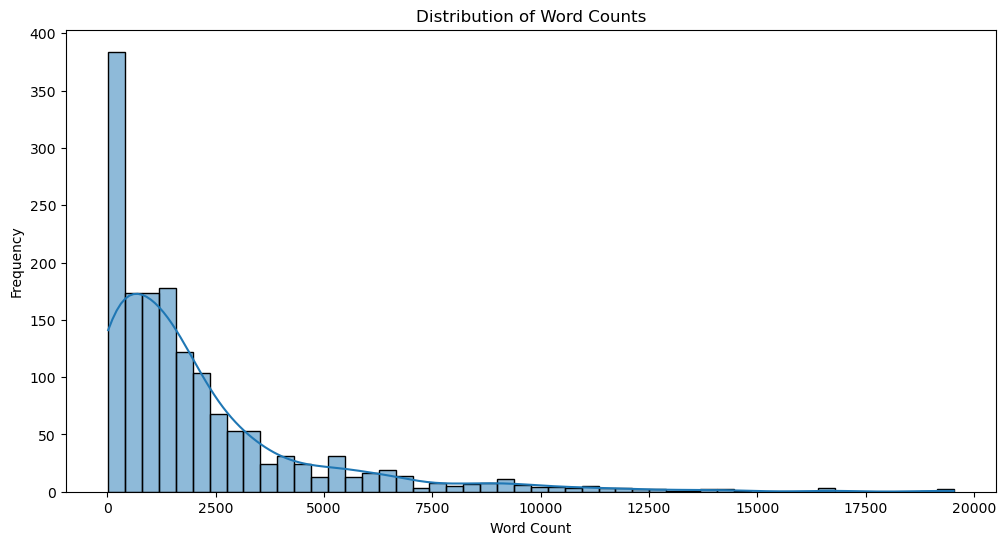

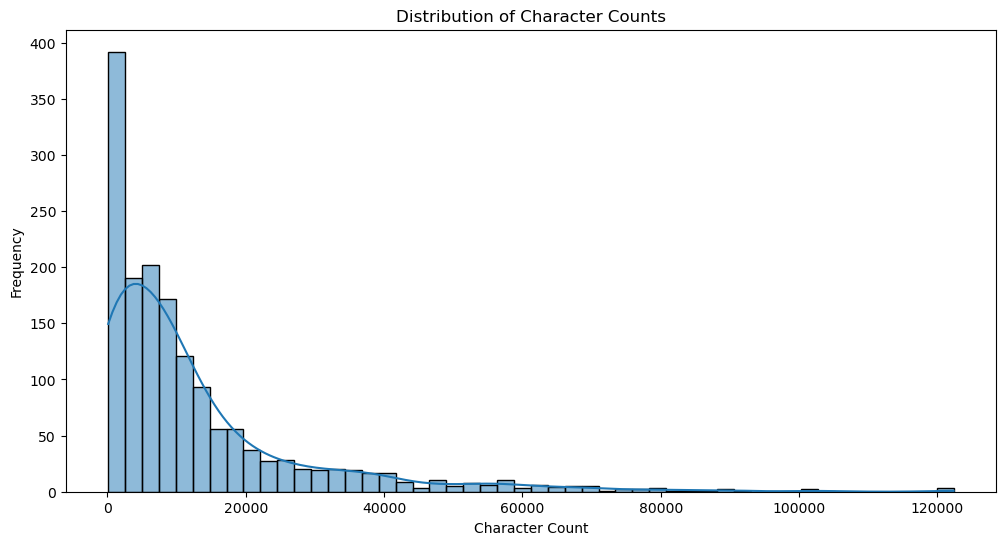

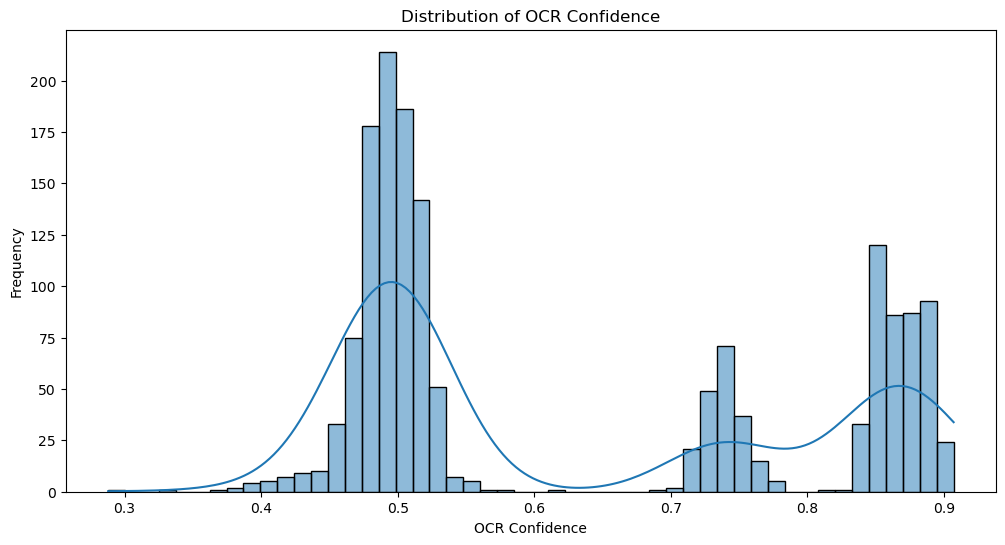

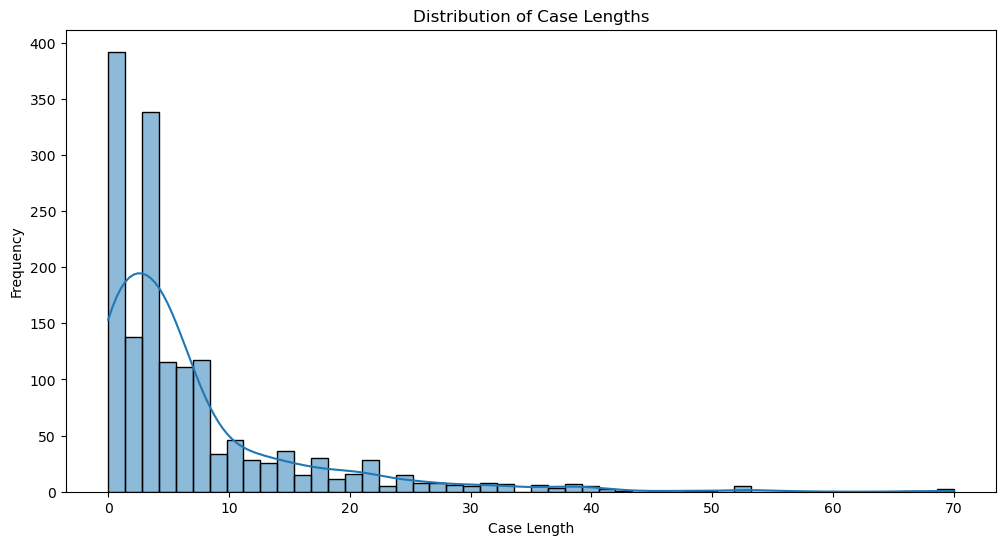

In [176]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of word counts
plt.figure(figsize=(12, 6))
sns.histplot(scotus_data['analysis.word_count'], bins=50, kde=True)
plt.title('Distribution of Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

# Distribution of character counts
plt.figure(figsize=(12, 6))
sns.histplot(scotus_data['analysis.char_count'], bins=50, kde=True)
plt.title('Distribution of Character Counts')
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.show()

# Distribution of OCR confidence
plt.figure(figsize=(12, 6))
sns.histplot(scotus_data['analysis.ocr_confidence'], bins=50, kde=True)
plt.title('Distribution of OCR Confidence')
plt.xlabel('OCR Confidence')
plt.ylabel('Frequency')
plt.show()

# Distribution of case lengths
plt.figure(figsize=(12, 6))
sns.histplot(scotus_data['case_length'], bins=50, kde=True)
plt.title('Distribution of Case Lengths')
plt.xlabel('Case Length')
plt.ylabel('Frequency')
plt.show()


## 3.4.3 Bivariate Analysis<a id='3.4.3'></a>

## a. Relationship Between Word Count and Case Length

Here we can see a clear relationship between word_count and case_length, both are increasing proportionally.

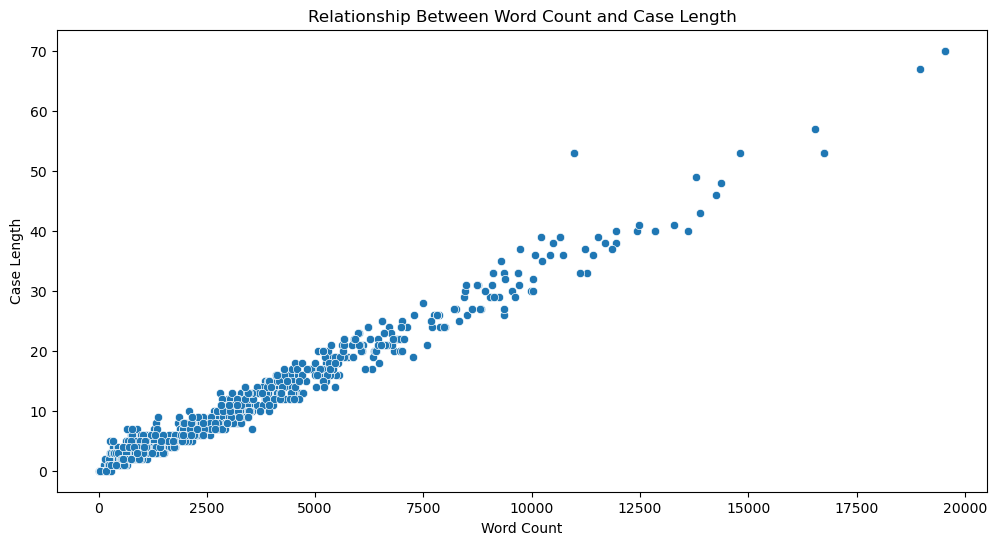

In [177]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=scotus_data, x='analysis.word_count', y='case_length')
plt.title('Relationship Between Word Count and Case Length')
plt.xlabel('Word Count')
plt.ylabel('Case Length')
plt.show()


## b. Relationship Between OCR Confidence and Character Count

The scatter plot of character count versus OCR confidence reveals three distinct clusters:

First Cluster: This group, with OCR confidence around 0.5 and character counts between 0 and 20,000, indicates lower OCR accuracy associated with shorter documents or sections.

Second Cluster: Found between 0.7 and 0.8 OCR confidence, this elongated cluster suggests a range of longer documents with higher OCR accuracy, with some outliers having exceptionally high character counts (up to 120,000).

Third Cluster: This cluster, around 0.9 OCR confidence and character counts between 0 and 8,000, represents high OCR accuracy for shorter documents, with a few outliers exhibiting very high character counts (100,000 to 120,000), indicating possible anomalies or special cases in the data.

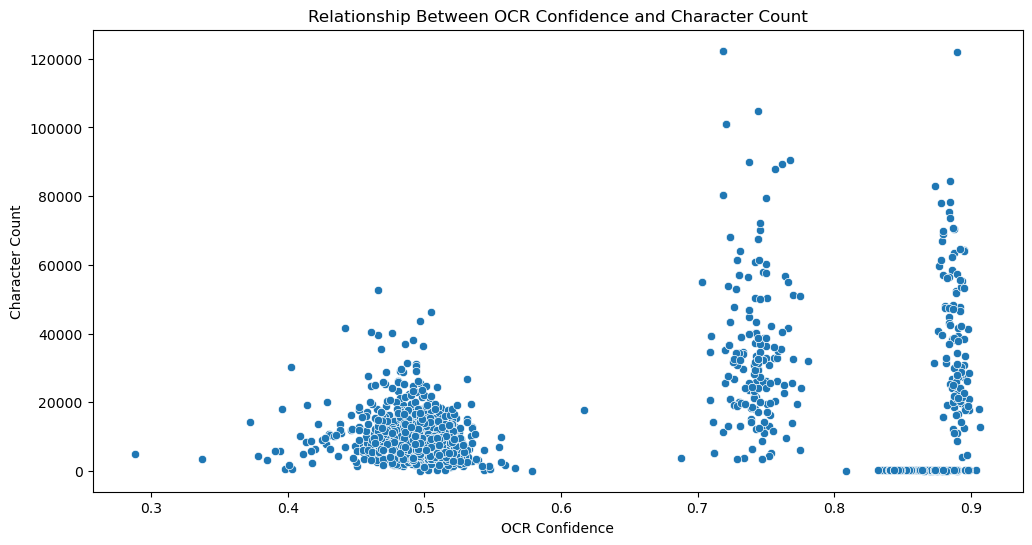

In [178]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=scotus_data, x='analysis.ocr_confidence', y='analysis.char_count')
plt.title('Relationship Between OCR Confidence and Character Count')
plt.xlabel('OCR Confidence')
plt.ylabel('Character Count')
plt.show()


## 3.4.4 Correlation Analysis<a id='3.4.4'></a>

## a. Correlation Matrix for Numerical Columns

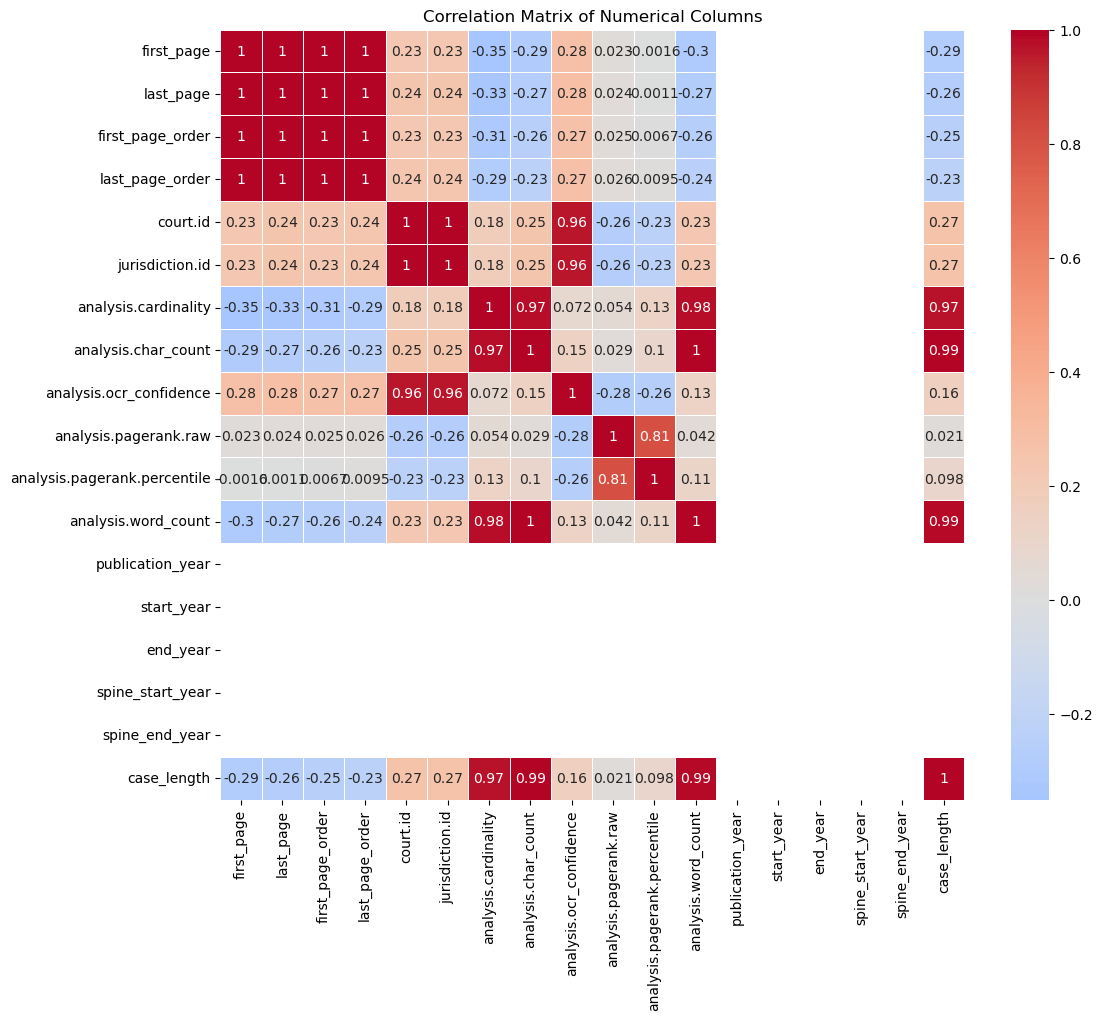

In [179]:
import numpy as np
# Identify numerical columns
numerical_columns = scotus_data.select_dtypes(include=[np.number]).columns

# Calculate the correlation matrix for numerical columns
corr_matrix = scotus_data[numerical_columns].corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Correlation Matrix of Numerical Columns')
plt.show()

## 3.4.5 Temporal Analysis of Case Trends Over Time<a id='3.4.5'></a>

## a. Number of Cases Decided Each Year

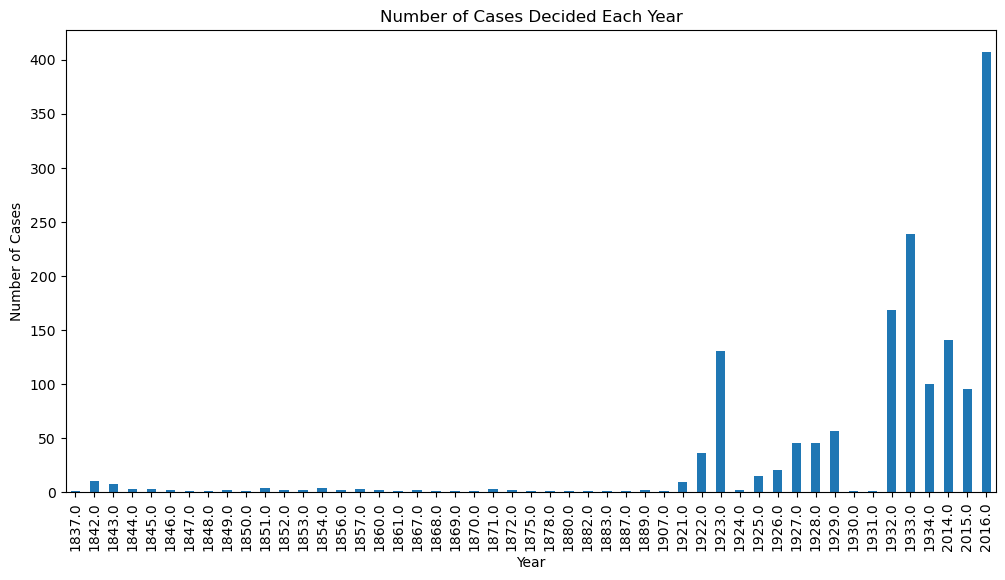

In [180]:
# Convert decision_date to datetime
scotus_data['decision_date'] = pd.to_datetime(scotus_data['decision_date'], errors='coerce')

# Extract year from decision_date
scotus_data['decision_year'] = scotus_data['decision_date'].dt.year

# Count cases per year
cases_per_year = scotus_data['decision_year'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
cases_per_year.plot(kind='bar')
plt.title('Number of Cases Decided Each Year')
plt.xlabel('Year')
plt.ylabel('Number of Cases')
plt.show()


## 3.4.6 Text Analysis<a id='3.4.6'></a>

## a. Word Cloud of Opinions

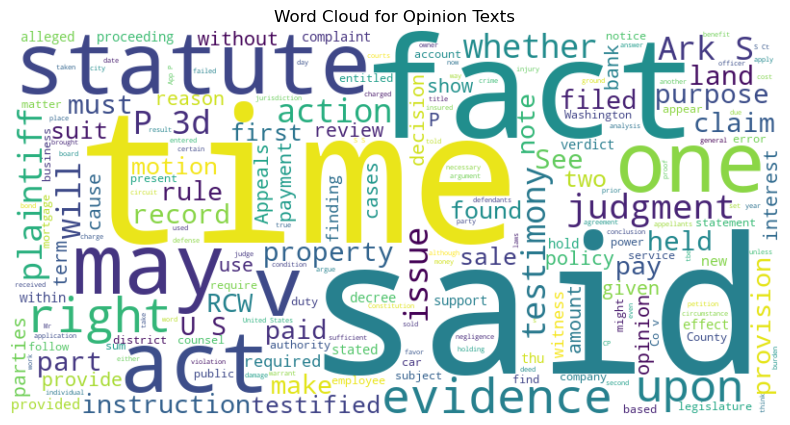

In [181]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# List of words to filter out
custom_stopwords = set(['appellee','Appeal','state','contract','appellant','P 3d','Id','case', 'Wn', '2d', 'question', 'court', 'trial', 'made', 'jury', 'law', 'person', 'defendant', 'order', 'W', 'section'])

# Combine all text data into a single string
text_data = ' '.join(scotus_data['opinion_text'].dropna())

# Update the default stopwords with custom stopwords
stopwords = STOPWORDS.union(custom_stopwords)

# Create a WordCloud object with the updated stopwords
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(text_data)

# Plot the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Opinion Texts')
plt.show()


## b. Character Count in Opinions

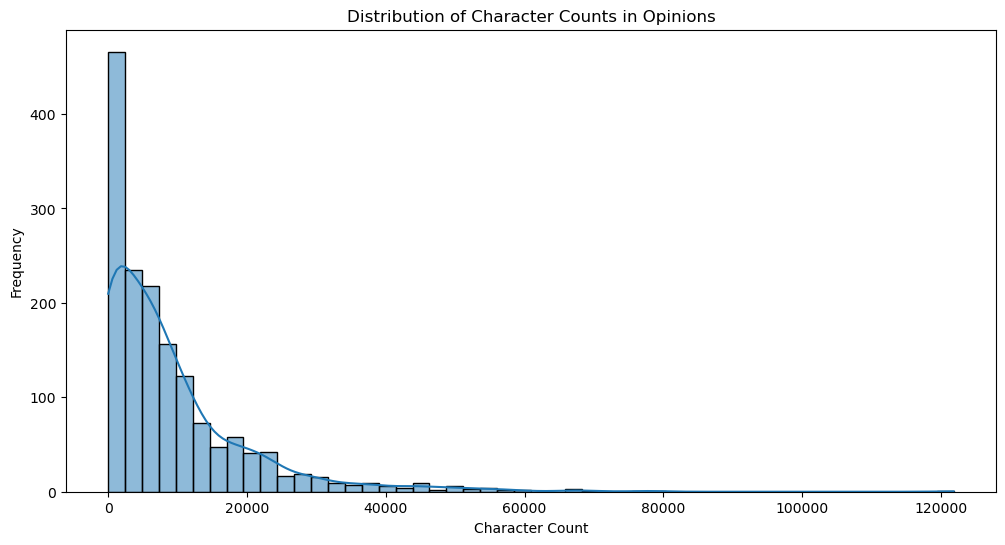

In [182]:
# Function to extract and join text from nested JSON lists
#def extract_text_from_opinion(opinions):
 #   text = ""
   # if isinstance(opinions, list):
  #      for opinion in opinions:
    #        if isinstance(opinion, dict) and 'text' in opinion:
     #           text += ' '.join(opinion['text'])
    #return text

# Apply the function to the column and calculate character count
#scotus_data['opinion_text'] = scotus_data['casebody.opinions'].apply(extract_text_from_opinion)
scotus_data['opinion_char_count'] = scotus_data['opinion_text'].apply(len)

# Plotting the distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.histplot(scotus_data['opinion_char_count'], bins=50, kde=True)
plt.title('Distribution of Character Counts in Opinions')
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.show()


## 3.4.7 Case and Court Analysis<a id='3.4.7'></a>

## a. Case Lengths and Citation Counts

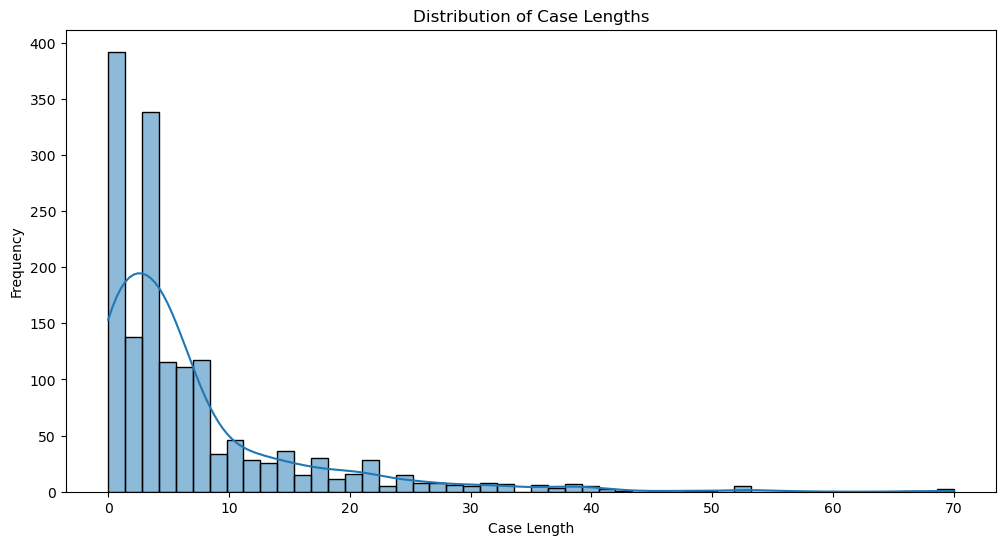

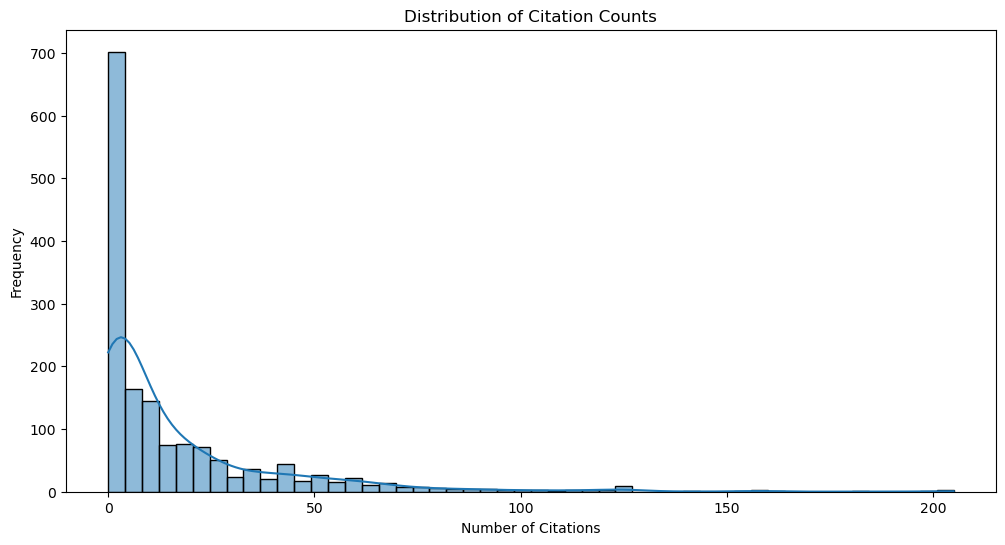

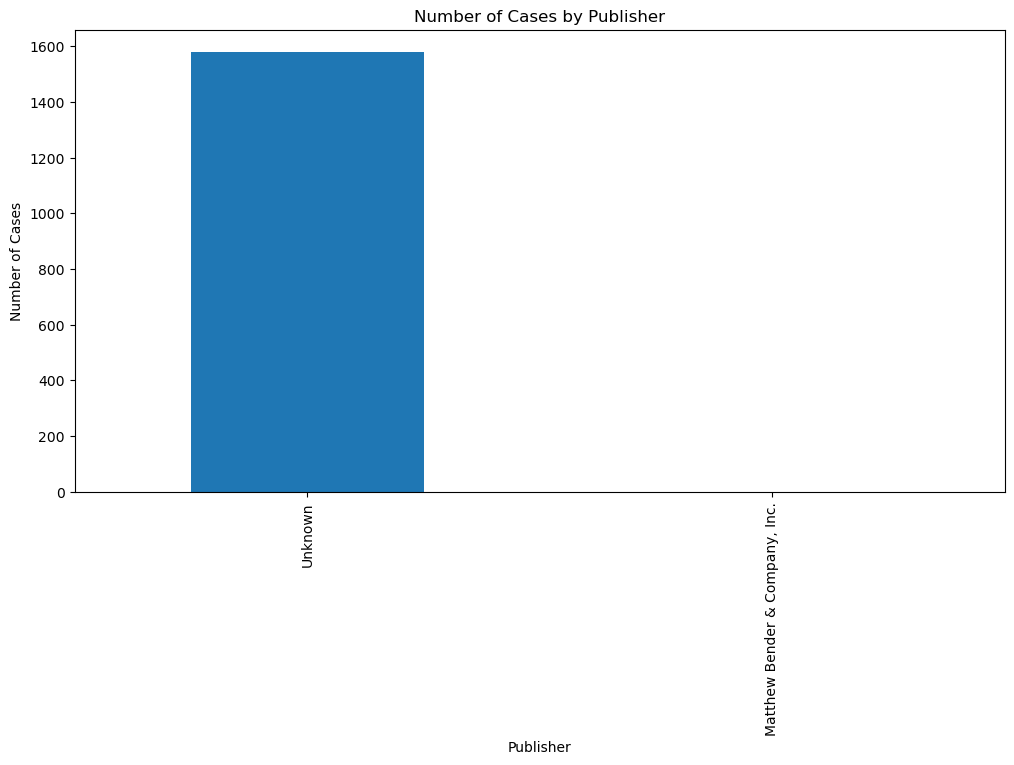

In [183]:
# Case Lengths Distribution
plt.figure(figsize=(12, 6))
sns.histplot(scotus_data['case_length'], bins=50, kde=True)
plt.title('Distribution of Case Lengths')
plt.xlabel('Case Length')
plt.ylabel('Frequency')
plt.show()

# Citation Counts Distribution
citation_counts = scotus_data['cites_to'].apply(len)  # Directly get the length of the list
plt.figure(figsize=(12, 6))
sns.histplot(citation_counts, bins=50, kde=True)
plt.title('Distribution of Citation Counts')
plt.xlabel('Number of Citations')
plt.ylabel('Frequency')
plt.show()

# Analysis of Publishers
publisher_counts = scotus_data['publisher'].value_counts()
plt.figure(figsize=(12, 6))
publisher_counts.plot(kind='bar')
plt.title('Number of Cases by Publisher')
plt.xlabel('Publisher')
plt.ylabel('Number of Cases')
plt.show()


## b. Court Analysis

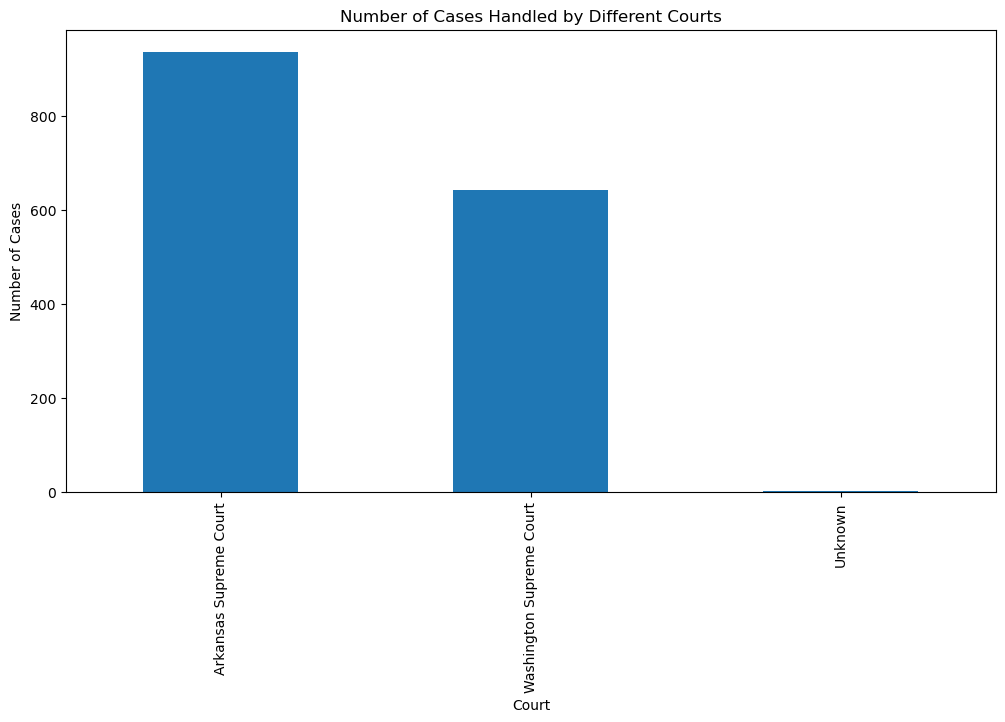

In [184]:
# Count cases per court
cases_per_court = scotus_data['court.name'].value_counts()
plt.figure(figsize=(12, 6))
cases_per_court.plot(kind='bar')
plt.title('Number of Cases Handled by Different Courts')
plt.xlabel('Court')
plt.ylabel('Number of Cases')
plt.show()


## 3.4.8 Analysis of Judges and Their Opinions<a id='3.4.8'></a>

## a. Frequency of Judges

In [185]:
# Count occurrences of each judge
judge_counts = scotus_data['casebody_judges'].value_counts()
print(judge_counts)

Unknown              386
Smith, J.            128
Humphreys, J.        114
Butler, J.            76
McHaney, J.           63
                    ... 
Meuaffy, J.            1
Mr. Justice Hanly      1
Macuxn                 1
Mehafey, J.            1
McHaNEy, J.            1
Name: casebody_judges, Length: 151, dtype: int64


## b. Sentiment Analysis of Opinions

In [186]:
from textblob import TextBlob

# Define a function to analyze sentiment
def analyze_sentiment(text):
    try:
        analysis = TextBlob(text)
        return analysis.sentiment.polarity
    except Exception as e:
        return None

# Apply sentiment analysis
scotus_data['opinion_sentiment'] = scotus_data['casebody.opinions'].apply(lambda x: analyze_sentiment(json.dumps(x)))
print(scotus_data[['casebody_judges', 'opinion_sentiment']].head())


   casebody_judges  opinion_sentiment
0      Wiggins, J.           0.011637
1    Humphreys, J.          -0.003222
2        Smith, J.           0.045642
3         Wood, J.           0.128645
4  Johnson, C. J.,          -0.020170


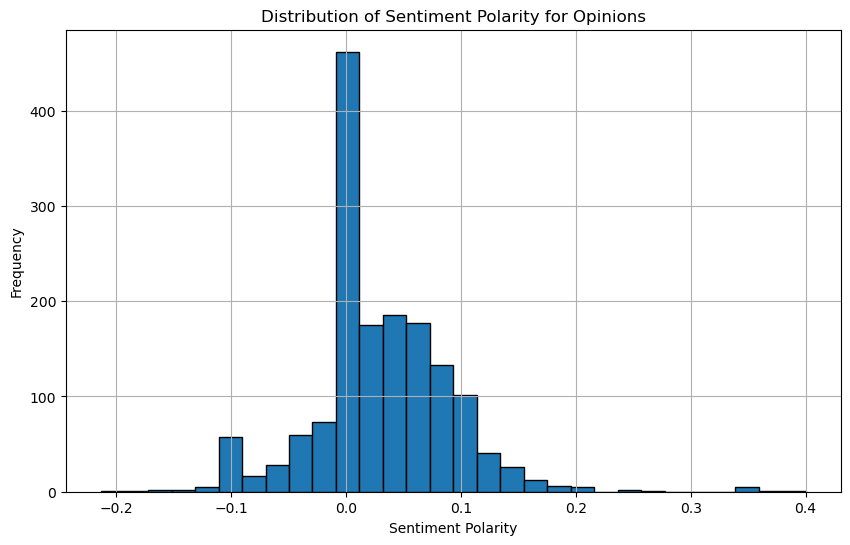

In [187]:
import matplotlib.pyplot as plt

# Drop rows with None or NaN sentiment values
sentiment_data = scotus_data.dropna(subset=['opinion_sentiment'])

# Plot the sentiment scores
plt.figure(figsize=(10, 6))
plt.hist(sentiment_data['opinion_sentiment'], bins=30, edgecolor='black')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Polarity for Opinions')
plt.grid(True)
plt.show()


# 3.5 Feature Engineering<a id='3.5'></a>

In [189]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# Extract TF-IDF features from opinion text
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_text = vectorizer.fit_transform(scotus_data['opinion_text'])

# Encoding categorical features
label_encoder = LabelEncoder()
scotus_data['court.name_abbreviation'] = label_encoder.fit_transform(scotus_data['court.name_abbreviation'])


# 3.6 Model Generation and Evaluation<a id='3.6'></a>

## 3.6.1 Evaluation summary<a id='3.6.1'></a>

**NER Model:**  
Used to identify decision date from casebody head matter. There was a challenge with multiple dates present, so the most probable location in the head matter was selected to pull the decision or opinion delivered date.  
- **Performance:** Demonstrates outstanding performance with negligible overfitting, effectively identifying decision dates from complex legal texts.

**Text Summarization (BART):**  
Used the case name to create the case summary and used the case name abbreviation as a baseline to evaluate the model.  
- **Performance:** Shows promising results with high recall but lower precision and F1 scores, suggesting room for improvement in summary quality.

**Document Classification:**  
Used a short snippet of case body head matter to pull the case decision and used opinion type as a baseline to evaluate the model.  
- **Performance:** Achieves perfect classification accuracy, indicating robust performance in categorizing legal opinions.


## 3.6.2 Named Entity Recognition (NER)<a id='3.6.2'></a>

In [200]:
import spacy
from dateutil import parser
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Load the spaCy model for NER
nlp = spacy.load("en_core_web_sm")

# Function to extract 50 characters next to keywords for NER prediction
def extract_context(text):
    match = re.search(r'(Decided|decided|Delivered|delivered)', text)
    if match:
        start = match.end()
        return text[start:start+1000]
    return ""

# Apply the function to extract context for NER
scotus_data['context_for_ner'] = scotus_data['casebody.head_matter'].apply(extract_context)

# Function to extract decision dates from text using regex
def extract_decision_date(text):
    match = re.search(r'(Decided|decided|Delivered|delivered)\s+([A-Za-z]+\s+\d{1,2},\s+\d{4})', text)
    if match:
        date_str = match.group(2)
        try:
            date = parser.parse(date_str, fuzzy=False).date()
            return date
        except (ValueError, TypeError):
            return None
    return None

# Function to extract decision dates using spaCy's NER
def extract_dates_spacy(text):
    doc = nlp(text)
    dates = []
    for ent in doc.ents:
        if ent.label_ == "DATE":
            try:
                parsed_date = parser.parse(ent.text, fuzzy=False).date()
                if 1900 < parsed_date.year < 2100:
                    dates.append(parsed_date)
            except (ValueError, TypeError):
                pass
    return dates[0] if dates else None

# Split the data into training and testing sets
train_data, test_data = train_test_split(scotus_data, test_size=0.2, random_state=42)

# Apply the functions to extract decision dates on training data
train_data['ground_truth_dates'] = train_data['casebody.head_matter'].apply(extract_decision_date)
train_data['predicted_dates'] = train_data['context_for_ner'].apply(extract_dates_spacy)

# Apply the functions to extract decision dates on testing data
test_data['ground_truth_dates'] = test_data['casebody.head_matter'].apply(extract_decision_date)
test_data['predicted_dates'] = test_data['context_for_ner'].apply(extract_dates_spacy)

# Convert the dates to string for classification metrics
train_data['ground_truth_dates'] = train_data['ground_truth_dates'].astype(str)
train_data['predicted_dates'] = train_data['predicted_dates'].astype(str)
test_data['ground_truth_dates'] = test_data['ground_truth_dates'].astype(str)
test_data['predicted_dates'] = test_data['predicted_dates'].astype(str)

# Calculate overall accuracy, precision, recall, and F1-score for the training data
train_accuracy = accuracy_score(train_data['ground_truth_dates'], train_data['predicted_dates'])
train_precision, train_recall, train_f1_score, _ = precision_recall_fscore_support(
    train_data['ground_truth_dates'], train_data['predicted_dates'], average='weighted', zero_division=0
)

# Calculate overall accuracy, precision, recall, and F1-score for the test data
test_accuracy = accuracy_score(test_data['ground_truth_dates'], test_data['predicted_dates'])
test_precision, test_recall, test_f1_score, _ = precision_recall_fscore_support(
    test_data['ground_truth_dates'], test_data['predicted_dates'], average='weighted', zero_division=0
)

# Print the evaluation results for training data
print(f"Model Performance on Training Data:")
print(f"Accuracy: {train_accuracy * 100:.2f}%")
print(f"Precision: {train_precision * 100:.2f}%")
print(f"Recall: {train_recall * 100:.2f}%")
print(f"F1 Score: {train_f1_score * 100:.2f}%")

# Print the evaluation results for test data
print(f"\nModel Performance on Test Data:")
print(f"Accuracy: {test_accuracy * 100:.2f}%")
print(f"Precision: {test_precision * 100:.2f}%")
print(f"Recall: {test_recall * 100:.2f}%")
print(f"F1 Score: {test_f1_score * 100:.2f}%")

# Compare training and test results
print(f"\nOverfitting Check:")
print(f"Difference in Accuracy: {train_accuracy - test_accuracy:.4f}")
print(f"Difference in Precision: {train_precision - test_precision:.4f}")
print(f"Difference in Recall: {train_recall - test_recall:.4f}")
print(f"Difference in F1 Score: {train_f1_score - test_f1_score:.4f}")


Model Performance on Training Data:
Accuracy: 99.76%
Precision: 100.00%
Recall: 99.76%
F1 Score: 99.88%

Model Performance on Test Data:
Accuracy: 99.37%
Precision: 100.00%
Recall: 99.37%
F1 Score: 99.68%

Overfitting Check:
Difference in Accuracy: 0.0039
Difference in Precision: 0.0000
Difference in Recall: 0.0039
Difference in F1 Score: 0.0020


## 3.6.3 Text Summarization<a id='3.6.3'></a>

In [202]:
import pandas as pd
from transformers import BartTokenizer, BartForConditionalGeneration
from sklearn.model_selection import train_test_split
from rouge_score import rouge_scorer
from sklearn.metrics import precision_recall_fscore_support

# Split the dataset into training and test sets
train_data, test_data = train_test_split(scotus_data, test_size=0.2, random_state=42)

# Load the pre-trained BART model and tokenizer
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')

def summarize_text(text, max_input_length=1000, summary_max_length=500, min_length=40):
    # Tokenize the text
    inputs = tokenizer(text, max_length=max_input_length, truncation=True, return_tensors="pt")
    
    # Generate the summary
    summary_ids = model.generate(
        inputs['input_ids'],
        max_length=summary_max_length,
        min_length=min_length,
        length_penalty=2.0,
        num_beams=4,
        early_stopping=True
    )
    
    # Decode the generated summary
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Apply the summarization to the 'name' column in the test set
test_data['generated_summary'] = test_data['name'].apply(summarize_text)

# Evaluate using ROUGE
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

def evaluate_summary(row):
    reference = row['name_abbreviation']
    generated = row['generated_summary']
    scores = scorer.score(reference, generated)
    return scores

# Apply the evaluation
test_data['rouge_scores'] = test_data.apply(evaluate_summary, axis=1)

# Aggregate ROUGE scores
def aggregate_scores(rouge_scores):
    avg_scores = {
        'rouge1': {'precision': 0, 'recall': 0, 'fmeasure': 0},
        'rouge2': {'precision': 0, 'recall': 0, 'fmeasure': 0},
        'rougeL': {'precision': 0, 'recall': 0, 'fmeasure': 0}
    }
    
    total = len(rouge_scores)
    for score in rouge_scores:
        for key in avg_scores:
            avg_scores[key]['precision'] += score[key].precision
            avg_scores[key]['recall'] += score[key].recall
            avg_scores[key]['fmeasure'] += score[key].fmeasure
    
    for key in avg_scores:
        avg_scores[key]['precision'] /= total
        avg_scores[key]['recall'] /= total
        avg_scores[key]['fmeasure'] /= total
    
    return avg_scores

# Convert the ROUGE scores from dict to list
rouge_scores_list = test_data['rouge_scores'].apply(pd.Series).to_dict(orient='records')

# Compute the aggregated ROUGE scores
aggregated_scores = aggregate_scores(rouge_scores_list)

# Print aggregated ROUGE scores
print("Aggregated ROUGE Scores:")
for key, metrics in aggregated_scores.items():
    print(f"{key.capitalize()} - Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, Fmeasure: {metrics['fmeasure']:.4f}")

# Optionally, display the first few results for inspection
for i, row in test_data.head(10).iterrows():
    print(f"Original Text {i + 1}: {row['name']}")
    print(f"Name Abbreviation {i + 1}: {row['name_abbreviation']}")
    print(f"Generated Summary {i + 1}: {row['generated_summary']}")
    print(f"ROUGE Scores {i + 1}: {row['rouge_scores']}")
    print()


C:\Users\Aditi\OneDrive\Documents\Python\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Aggregated ROUGE Scores:
Rouge1 - Precision: 0.1279, Recall: 0.9099, Fmeasure: 0.2200
Rouge2 - Precision: 0.0757, Recall: 0.5974, Fmeasure: 0.1309
Rougel - Precision: 0.1279, Recall: 0.9099, Fmeasure: 0.2200
Original Text 84: West Twelfth Street Improvement District No. 30 v. Kinstley
Name Abbreviation 84: West Twelfth Street Improvement District No. 30 v. Kinstley
Generated Summary 84: West Twelfth Street Improvement District No. 30 v. Kinstley was a case in which the court ruled in favor of the Improvement District. The case was heard in the U.S. District Court for the Eastern District of New York.
ROUGE Scores 84: {'rouge1': Score(precision=0.225, recall=1.0, fmeasure=0.36734693877551017), 'rouge2': Score(precision=0.20512820512820512, recall=1.0, fmeasure=0.3404255319148936), 'rougeL': Score(precision=0.225, recall=1.0, fmeasure=0.36734693877551017)}

Original Text 54: Producers' Sand & Gravel Company, Inc., v. Patterson
Name Abbreviation 54: Producers' Sand & Gravel Co. v. Patters

## 3.6.4 Document Classification<a id='3.6.4'></a>

In [204]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Limit the data to 100 rows for this example
scotus_data_sample = scotus_data.copy()

# Preprocess the data
def assign_label(text):
    text = text[:50].lower()  # Extract the first 50 characters and convert to lowercase
    if 'concurrence' in text:
        return 'concurrence'
    elif 'dissent' in text:
        return 'dissent'
    else:
        return 'majority'

# Apply the label assignment
scotus_data_sample['label'] = scotus_data_sample['opinion_text'].apply(assign_label)

# Split the data into features and labels
X = scotus_data_sample['opinion_text'].apply(lambda x: x[:500])  # Use first 500 characters
y = scotus_data_sample['label']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize the text data
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Train the Naive Bayes model
model = MultinomialNB()
model.fit(X_train_vec, y_train)

# Predict the labels for the test set
y_pred = model.predict(X_test_vec)

# Display the classified values
classified_results = pd.DataFrame({
    'Original Text': X_test,
    'Predicted Label': y_pred,
    'True Label': scotus_data_sample.loc[X_test.index, 'opinion_type']  # Use the casebody.opinions.type column for evaluation
})

print("Classified Results:")
print(classified_results)

# Evaluate the model
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classified Results:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    Original Text  \
1124                                                                                                                                                                                                                                                                                                                                                                                          Petition for review of a decision of the Court of Appeals, No. 70860-1-1, March 2

# 3.7 Future Recommendations<a id='3.7'></a>

**1. Named Entity Recognition (NER) for Decision Date Extraction**

**Recommendations:**
- Regular monitoring to ensure continued accuracy.
- Expand training data to enhance robustness.
- Explore advanced models like BERT for potential improvements.

**Next Steps:**
- Periodically re-evaluate with new data.
- Document performance metrics and updates.

---

**2. Text Summarization with BART**

**Recommendations:**
- Fine-tune BART on legal text for better summaries.
- Consider hybrid summarization methods.
- Explore additional evaluation metrics like BLEU.

**Next Steps:**
- Augment the dataset with more diverse examples.
- Tune model parameters for better precision and F1 scores.
- Incorporate feedback from legal professionals.

---

**3. Document Classification for Opinion Type**

**Recommendations:**
- Validate on larger, diverse datasets.
- Review and address edge cases.
- Obtain domain expert feedback.

**Next Steps:**
- Test scalability with larger datasets.
- Implement continual learning mechanisms.
- Integrate the model into legal workflows.
